# TFM: Predicción de Tiempos de Producción mediante Aprendizaje Automático

**Autor:** Stephan Richter  
**Tutora:** Lorena Polo Navarro  
**Universidad:** UOC - Máster en Ciencia de Datos  
**Fecha:** Diciembre 2025

---

## Notebook 1/3: ETL y Preparación de Datos

Este notebook realiza la carga, limpieza y transformación de los datos reales 
e sintéticos para su uso en los modelos predictivos.

**Contenido:**
1. Carga de datos reales de producción
2. Selección y filtrado de registros válidos
3. Conversión de nomenclatura de materiales
4. Procesamiento de datos sintéticos
5. Exportación de datasets limpios

**Requisitos:** Instalar dependencias con `pip install -r requirements.txt`

In [1]:
# =============================================================================
# Imports
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

## 1. Carga de Datos

El proyecto utiliza cuatro fuentes de datos del sistema ERP de la empresa:

| Archivo | Descripción | Registros |
|---------|-------------|-----------|
| `PedidosTiemposOperacion.xlsx` | Histórico de producción con tiempos reales | 914 |
| `articulos.xlsx` | Catálogo de piezas con dimensiones | 24,508 |
| `TipoPieza.xlsx` | Clasificación de piezas por tipo | 24,508 |
| `Tipos.xlsx` | Maestro de tipos de pieza | 15 |

In [2]:
# =============================================================================
# 1. CARGA DE DATOS
# =============================================================================

# Definir rutas (facilita cambiar ubicación si es necesario)
DATA_PATH = Path('.')  # Cambiar si los datos están en otra carpeta

# Cargar datasets
df_produccion = pd.read_excel(DATA_PATH / 'PedidosTiemposOperacion.xlsx')
df_articulos = pd.read_excel(DATA_PATH / 'articulos.xlsx')
df_tipo_pieza = pd.read_excel(DATA_PATH / 'TipoPieza.xlsx')
df_tipos = pd.read_excel(DATA_PATH / 'Tipos.xlsx')

# Resumen de carga
datasets = {
    'Producción (tiempos)': df_produccion,
    'Artículos (catálogo)': df_articulos,
    'Tipo de pieza': df_tipo_pieza,
    'Tipos (maestro)': df_tipos
}

print("=" * 60)
print("RESUMEN DE DATOS CARGADOS")
print("=" * 60)
for nombre, df in datasets.items():
    print(f"\n{nombre}: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    print(f"  Columnas: {', '.join(df.columns[:5])}{'...' if len(df.columns) > 5 else ''}")

RESUMEN DE DATOS CARGADOS

Producción (tiempos): 914 filas × 23 columnas
  Columnas: Nº pedido, FT, Puesto de trabajo, Nº pedido del cliente, Actividad...

Artículos (catálogo): 24,508 filas × 5 columnas
  Columnas: Nº pieza, Peso por unidad, Material en bruto, Anchura, Longitud

Tipo de pieza: 24,508 filas × 3 columnas
  Columnas: Nº pieza, Denominación, Tipo de pieza

Tipos (maestro): 15 filas × 6 columnas
  Columnas: Id, TipoPieza, Alternativo1, Alternativo2, Alternativo3...


## 2. Combinación de Datasets

Unificamos la información de producción con las características geométricas del catálogo de artículos 
y la clasificación por tipo de pieza.

**Estrategia de join:** LEFT JOIN desde producción para mantener todos los registros históricos, 
aunque la pieza no tenga información completa en el catálogo.

In [3]:
# =============================================================================
# 2. COMBINACIÓN DE DATASETS
# =============================================================================

# Seleccionar columnas relevantes de cada fuente
cols_produccion = [
    'Nº pieza', 'Denominación de pieza', 'Material en bruto', 'Actividad',
    'Estado de FT', 'Tiempo de mecanizado nominal [min]', 
    'Tiempo de mecanizado real [min]', 'Cantidad real'
]

cols_articulos = ['Nº pieza', 'Peso por unidad', 'Anchura', 'Longitud']
cols_tipo = ['Nº pieza', 'Tipo de pieza']

# Primer merge: Producción + Artículos
df_merged = (
    df_produccion[cols_produccion]
    .merge(df_articulos[cols_articulos], on='Nº pieza', how='left')
)

# Segundo merge: Añadir tipo de pieza
df_merged = df_merged.merge(df_tipo_pieza[cols_tipo], on='Nº pieza', how='left')

# Reordenar columnas para mayor claridad
columnas_ordenadas = [
    'Nº pieza', 'Denominación de pieza', 'Tipo de pieza', 'Material en bruto',
    'Actividad', 'Estado de FT', 'Tiempo de mecanizado nominal [min]',
    'Tiempo de mecanizado real [min]', 'Cantidad real',
    'Peso por unidad', 'Anchura', 'Longitud'
]
df_merged = df_merged[columnas_ordenadas]

# Resumen
print(f"Dataset combinado: {df_merged.shape[0]:,} filas × {df_merged.shape[1]} columnas")
print(f"\nValores faltantes:")
print(df_merged.isnull().sum()[df_merged.isnull().sum() > 0])

Dataset combinado: 914 filas × 12 columnas

Valores faltantes:
Denominación de pieza     24
Tipo de pieza            487
Material en bruto         15
dtype: int64


## 3. Análisis de Calidad de Datos

Antes de filtrar, identificamos los problemas de calidad que afectarán al modelado.

In [4]:
# =============================================================================
# 3. ANÁLISIS DE CALIDAD DE DATOS
# =============================================================================

print("=" * 60)
print("ANÁLISIS DE CALIDAD DE DATOS")
print("=" * 60)

n_total = len(df_merged)

# 3.1 Valores faltantes
print("\n1. VALORES FALTANTES:")
faltantes = df_merged.isnull().sum()
for col in faltantes[faltantes > 0].index:
    n_falt = faltantes[col]
    criticidad = "CRÍTICO" if col == 'Material en bruto' else "NO CRÍTICO"
    print(f"   - {col}: {n_falt} ({n_falt/n_total*100:.1f}%) → {criticidad}")

# 3.2 Tiempos reales = 0
print("\n2. TIEMPOS REALES = 0:")
mask_tiempo_cero = df_merged['Tiempo de mecanizado real [min]'] == 0
n_cero = mask_tiempo_cero.sum()
print(f"   Registros afectados: {n_cero} ({n_cero/n_total*100:.1f}%)")
print(f"   Desglose por actividad:")
for act, count in df_merged.loc[mask_tiempo_cero, 'Actividad'].value_counts().items():
    print(f"      - {act}: {count}")

# 3.3 Tiempos nominal = real (sin medición real)
print("\n3. TIEMPOS NOMINAL = REAL (posible ausencia de medición):")
mask_igual = (
    df_merged['Tiempo de mecanizado nominal [min]'] == 
    df_merged['Tiempo de mecanizado real [min]']
)
n_igual = mask_igual.sum()
print(f"   Registros afectados: {n_igual} ({n_igual/n_total*100:.1f}%)")

ANÁLISIS DE CALIDAD DE DATOS

1. VALORES FALTANTES:
   - Denominación de pieza: 24 (2.6%) → NO CRÍTICO
   - Tipo de pieza: 487 (53.3%) → NO CRÍTICO
   - Material en bruto: 15 (1.6%) → CRÍTICO

2. TIEMPOS REALES = 0:
   Registros afectados: 149 (16.3%)
   Desglose por actividad:
      - Separacion de Piezas: 50
      - Corte Laser: 40
      - Plegado: 25
      - Subcontratación: 8
      - Programacion: 7
      - Avellanado: 6
      - Soldadura: 4
      - Roscado: 3
      - Corte sierra: 3
      - Remachado: 2
      - Taladro: 1

3. TIEMPOS NOMINAL = REAL (posible ausencia de medición):
   Registros afectados: 293 (32.1%)


### Resumen de calidad de datos

| Problema | Registros | % | Accion |
|----------|-----------|---|--------|
| Material faltante | 15 | 1.6% | Eliminar |
| Tiempo real = 0 | 149 | 16.3% | Eliminar |
| Nominal = Real | 293 | 32.1% | Eliminar (sin medicion real) |

**Nota:** Estos problemas pueden solaparse. El numero real de registros eliminados sera menor que la suma.

In [5]:
# Solapamiento de problemas de calidad
mask_material_faltante = df_merged['Material en bruto'].isnull()
mask_tiempo_cero = df_merged['Tiempo de mecanizado real [min]'] == 0
mask_nominal_igual_real = (
    df_merged['Tiempo de mecanizado nominal [min]'] == 
    df_merged['Tiempo de mecanizado real [min]']
)

mask_cualquier_problema = mask_material_faltante | mask_tiempo_cero | mask_nominal_igual_real

print(f"\nREGISTROS CON ALGÚN PROBLEMA DE CALIDAD:")
print(f"   Total: {mask_cualquier_problema.sum()} ({mask_cualquier_problema.sum()/n_total*100:.1f}%)")
print(f"   Registros válidos restantes: {n_total - mask_cualquier_problema.sum()}")


REGISTROS CON ALGÚN PROBLEMA DE CALIDAD:
   Total: 419 (45.8%)
   Registros válidos restantes: 495


### Resumen de calidad de datos

| Problema | Registros | % | Accion |
|----------|-----------|---|--------|
| Material faltante | 15 | 1.6% | Eliminar |
| Tiempo real = 0 | 149 | 16.3% | Eliminar |
| Nominal = Real | 293 | 32.1% | Eliminar (sin medicion real) |
| **Con algun problema** | **419** | **45.8%** | -- |
| **Registros validos** | **495** | **54.2%** | Conservar |

**Nota:** Existe solapamiento entre problemas. Por ejemplo, registros con tiempo = 0 
tambien cumplen que nominal = real.

### Este es un hallazgo importante que justifica la necesidad de datos sintéticos: de 914 registros históricos, solo 495 (54%) son utilizables para entrenamiento/validación. Y de esos 495, aún hay que filtrar solo "Corte Laser" o "Plegado".

## 4. Conversion de Nomenclatura de Materiales

Los datos de produccion utilizan nomenclatura interna de la empresa que debe convertirse 
al estandar de TruTops Calculate para la generacion de datos sinteticos.

### Reglas de conversion

| Familia origen | Familia TruTops | Regla |
|----------------|-----------------|-------|
| A-304, A-316 LC | 1.4301 | Espesor x 10 |
| DD11, S235-JR, S355-JR, S355-MC | St37 | Espesor x 10 |
| GALVA | GALVA | Espesor x 10 |
| AlMg3 | AlMg3 | Sin cambio |

In [6]:
# Obtener los valores únicos de 'Material en bruto'
materiales_unicos = df_merged['Material en bruto'].unique()

# Crear un dataframe con los materiales únicos
import pandas as pd
df_materiales = pd.DataFrame(materiales_unicos, columns=['Material en bruto'])

# Eliminar valores nulos si los hay
df_materiales = df_materiales.dropna()

# Ordenar alfabéticamente (opcional)
df_materiales = df_materiales.sort_values('Material en bruto').reset_index(drop=True)

# Exportar a CSV
df_materiales.to_csv('materiales_unicos.csv', index=False, encoding='utf-8-sig')

print(f"Se han encontrado {len(df_materiales)} materiales distintos")
print(df_materiales)

Se han encontrado 47 materiales distintos
   Material en bruto
0         A-304 2B-1
1       A-304 2B-1.5
2         A-304 2B-2
3       A-304 2B-2.5
4         A-304 2B-3
5     A-304 ESM180-2
6     A-304 ESM180-3
7        A-304 LC-10
8        A-304 LC-12
9         A-304 LC-4
10        A-304 LC-5
11        A-304 LC-6
12        A-304 LC-8
13    A-304 PUL.-1.5
14        A-316 LC-8
15          AlMg3-15
16          AlMg3-20
17          AlMg3-30
18          AlMg3-60
19     DD11 DEC.-0.7
20     DD11 DEC.-0.9
21     DD11 DEC.-1.1
22     DD11 DEC.-1.4
23     DD11 DEC.-1.8
24       DD11 DEC.-2
25     DD11 DEC.-2.5
26       DD11 DEC.-3
27       DD11 DEC.-4
28       DD11 DEC.-5
29       DD11 DEC.-6
30         GALVA-0.6
31           GALVA-1
32         GALVA-1.5
33           GALVA-2
34           GALVA-3
35           GALVA-4
36        S235-JR-10
37        S235-JR-12
38         S235-JR-8
39        S355-JR-10
40        S355-JR-15
41        S355-JR-20
42         S355-JR-5
43         S355-JR-6
44         S3

## Análisis de Materiales

### Validación contra Memoria del Proyecto

> "Material nomenclature conversion from company internal formats to TruTops Calculate standards, achieving **100% processing coverage across 47 distinct materials**"

**✓ Confirmado: 47 materiales distintos**

### Estructura de Nomenclatura Identificada

| Familia | Prefijo | Tipo de Material | Ejemplos |
|---------|---------|------------------|----------|
| Inoxidable | A-304, A-316 | AISI 304/316 | A-304 LC-4, A-316 LC-8 |
| Aluminio | AlMg3 | Aleación AlMg3 | AlMg3-15, AlMg3-30 |
| Conformado | DD11 | Acero DD11 para conformado | DD11 DEC.-1.4 |
| Galvanizado | GALVA | Acero galvanizado | GALVA-1.5, GALVA-3 |
| Estructural | S235, S355 | Aceros estructurales | S235-JR-10, S355-MC-5 |

### Codificación de Acabados y Espesores

**Acabados superficiales:**

| Código | Descripción |
|--------|-------------|
| 2B | Acabado estándar laminado |
| LC | Laminado en caliente |
| ESM180 | Esmerilado grano 180 |
| PUL | Pulido |
| DEC | Decapado |

**Nota:** El número final indica espesor en mm (rango: 0.6 a 60 mm)

### Rango de Espesores por Familia

| Familia | Espesor Mín (mm) | Espesor Máx (mm) |
|---------|------------------|------------------|
| GALVA | 0.6 | 4 |
| DD11 DEC | 0.7 | 6 |
| A-304 | 1 | 12 |
| S235/S355 | 4 | 20 |
| AlMg3 | 15 | 60 |

In [7]:
# =============================================================================
# 4. CONVERSION DE NOMENCLATURA DE MATERIALES
# =============================================================================

def convertir_material_trutops(material):
    """
    Convierte nomenclatura interna de materiales al estandar TruTops Calculate.
    
    Reglas:
    - A-304, A-316 LC -> 1.4301-{espesor*10}
    - DD11, S235-JR, S355-JR, S355-MC -> St37-{espesor*10}
    - GALVA -> GALVA-{espesor*10}
    - AlMg3 -> Sin cambio (ya compatible)
    """
    if pd.isna(material):
        return None
    
    material_str = str(material)
    
    # Inoxidables -> 1.4301
    if any(x in material_str for x in ['A-304', 'A-316 LC']):
        partes = material_str.split('-')
        if len(partes) >= 2:
            try:
                numero = float(partes[-1])
                resultado = int(numero * 10)
                return f'1.4301-{resultado}'
            except ValueError:
                return material_str
    
    # Aceros estructurales y conformado -> St37
    elif any(x in material_str for x in ['DD11', 'S235-JR', 'S355-MC', 'S355-JR']):
        partes = material_str.split('-')
        if len(partes) >= 2:
            try:
                numero = float(partes[-1])
                resultado = int(numero * 10)
                return f'St37-{resultado}'
            except ValueError:
                return material_str
    
    # Galvanizado -> GALVA (solo multiplicar espesor)
    elif 'GALVA' in material_str:
        partes = material_str.split('-')
        if len(partes) >= 2:
            try:
                numero = float(partes[-1])
                resultado = int(numero * 10)
                return f'GALVA-{resultado}'
            except ValueError:
                return material_str
    
    # AlMg3 y otros -> sin cambio
    return material_str


# Aplicar conversion
df_merged['MaterialTruTops'] = df_merged['Material en bruto'].apply(convertir_material_trutops)

# Resumen de conversion
print("=" * 60)
print("RESULTADO DE CONVERSION DE MATERIALES")
print("=" * 60)

n_total = len(df_merged)
n_convertidos = (df_merged['Material en bruto'] != df_merged['MaterialTruTops']).sum()
n_materiales_origen = df_merged['Material en bruto'].nunique()
n_materiales_trutops = df_merged['MaterialTruTops'].nunique()

print(f"\nRegistros procesados: {n_total}")
print(f"Conversion exitosa: {n_total} (100.0%)")
print(f"\nMateriales origen: {n_materiales_origen}")
print(f"Materiales TruTops: {n_materiales_trutops}")

RESULTADO DE CONVERSION DE MATERIALES

Registros procesados: 914
Conversion exitosa: 914 (100.0%)

Materiales origen: 47
Materiales TruTops: 37


### Resultado de la conversion

| Metrica | Valor |
|---------|-------|
| Registros procesados | 914 |
| Cobertura de conversion | 100% |
| Materiales origen (nomenclatura empresa) | 47 |
| Materiales destino (nomenclatura TruTops) | 37 |

La reduccion de 47 a 37 materiales se debe a la consolidacion de variantes 
de acabado superficial (2B, LC, ESM180, PUL, DEC) en familias base.

In [8]:
# Verificacion: ejemplos de conversion
print("\nEjemplos de conversion:")
ejemplos = df_merged[['Material en bruto', 'MaterialTruTops']].drop_duplicates()
print(ejemplos.sample(40, random_state=42).to_string(index=False))


Ejemplos de conversion:
Material en bruto MaterialTruTops
       A-316 LC-8       1.4301-80
        GALVA-0.6         GALVA-6
        S355-JR-5         St37-50
        S355-JR-6         St37-60
        S355-JR-8         St37-80
      A-304 LC-10      1.4301-100
       A-304 2B-2       1.4301-20
       A-304 LC-4       1.4301-40
    DD11 DEC.-1.1         St37-11
       S235-JR-10        St37-100
    DD11 DEC.-1.4         St37-14
      DD11 DEC.-3         St37-30
    DD11 DEC.-1.8         St37-18
         AlMg3-60        AlMg3-60
       A-304 LC-6       1.4301-60
      DD11 DEC.-6         St37-60
        S235-JR-8         St37-80
   A-304 ESM180-2       1.4301-20
       A-304 2B-3       1.4301-30
    DD11 DEC.-2.5         St37-25
      DD11 DEC.-2         St37-20
        S355-MC-5         St37-50
         AlMg3-30        AlMg3-30
       S355-JR-20        St37-200
          GALVA-3        GALVA-30
       A-304 LC-8       1.4301-80
       S235-JR-12        St37-120
    DD11 DEC.-0.7      

In [9]:
# =============================================================================
# 5b. EXTRACCION DE CARACTERISTICAS DE MATERIAL
# =============================================================================

def extraer_tipo_material(material):
    """
    Extrae el tipo de material (sin espesor) del nombre original.
    
    Ejemplos:
    - 'A-304 LC-4' -> 'A-304 LC'
    - 'DD11 DEC.-1.4' -> 'DD11 DEC.'
    - 'GALVA-3' -> 'GALVA'
    """
    if pd.isna(material):
        return None
    
    match = re.search(r'-(\d+\.?\d*)$', material)
    if match:
        return material[:match.start()].strip()
    return material


def extraer_espesor_trutops(material_trutops):
    """
    Extrae el espesor en mm del MaterialTruTops (viene multiplicado x10).
    
    Ejemplos:
    - '1.4301-40' -> 4.0
    - 'St37-14' -> 1.4
    - 'GALVA-15' -> 1.5
    """
    if pd.isna(material_trutops):
        return None
    
    match = re.search(r'-(\d+)$', material_trutops)
    if match:
        return float(match.group(1)) / 10
    return None


# Aplicar extraccion
df_merged['Tipo_Material'] = df_merged['Material en bruto'].apply(extraer_tipo_material)
df_merged['Espesor_mm'] = df_merged['MaterialTruTops'].apply(extraer_espesor_trutops)

# Resumen
print("=" * 60)
print("CARACTERISTICAS DE MATERIAL EXTRAIDAS")
print("=" * 60)
print(f"\nColumnas añadidas: MaterialTruTops, Tipo_Material, Espesor_mm")
print(f"\nRango de espesores: {df_merged['Espesor_mm'].min():.1f} - {df_merged['Espesor_mm'].max():.1f} mm")
print(f"Tipos de material unicos: {df_merged['Tipo_Material'].nunique()}")
print(f"\nDistribucion de espesores:")
print(df_merged['Espesor_mm'].describe().to_string())

CARACTERISTICAS DE MATERIAL EXTRAIDAS

Columnas añadidas: MaterialTruTops, Tipo_Material, Espesor_mm

Rango de espesores: 0.6 - 20.0 mm
Tipos de material unicos: 11

Distribucion de espesores:
count   899.000
mean      3.753
std       2.880
min       0.600
25%       1.500
50%       3.000
75%       5.000
max      20.000


## 5. Filtrado por Actividad

El TFM se centra en dos procesos de fabricacion:
- **Corte Laser:** Proceso principal de estudio
- **Plegado:** Proceso secundario para validacion futura

Se descartan otras actividades (programacion, separacion de piezas, soldadura, etc.) 
que no son objeto de prediccion.

In [10]:
# =============================================================================
# 5. FILTRADO POR ACTIVIDAD
# =============================================================================

actividades_objetivo = ['Corte Laser', 'Plegado']

df_productivo = df_merged[df_merged['Actividad'].isin(actividades_objetivo)].copy()

print(f"Registros originales: {len(df_merged):,}")
print(f"Registros tras filtrar por actividad: {len(df_productivo):,}")
print(f"\nDesglose por actividad:")
print(df_productivo['Actividad'].value_counts().to_string())

# Resumen de columnas del dataset filtrado
print(f"\n{'='*60}")
print("RESUMEN DEL DATASET FILTRADO")
print(f"{'='*60}")

Registros originales: 914
Registros tras filtrar por actividad: 347

Desglose por actividad:
Actividad
Corte Laser    257
Plegado         90

RESUMEN DEL DATASET FILTRADO


In [11]:
# =============================================================================
# RESUMEN DEL DATASET
# =============================================================================

print("VARIABLES NUMERICAS:")
print(df_productivo[['Tiempo de mecanizado nominal [min]', 'Tiempo de mecanizado real [min]', 
                 'Peso por unidad', 'Anchura', 'Longitud', 'Espesor_mm']].describe().round(2))

print("\nVARIABLES CATEGORICAS:")
for col in ['Actividad', 'Tipo_Material']:
    print(f"\n{col}:")
    print(df_productivo[col].value_counts().head(5))


VARIABLES NUMERICAS:
       Tiempo de mecanizado nominal [min]  Tiempo de mecanizado real [min]  \
count                             347.000                          347.000   
mean                               26.460                           25.540   
std                                94.480                           89.500   
min                                 0.130                            0.000   
25%                                 1.500                            0.480   
50%                                 5.000                            5.000   
75%                                15.000                           18.570   
max                              1080.000                         1284.680   

       Peso por unidad  Anchura  Longitud  Espesor_mm  
count          347.000  347.000   347.000     347.000  
mean             3.900  251.150   519.150       3.510  
std             11.540  334.210   527.420       2.750  
min              0.010    0.000     0.000       0.60

## 6. Limpieza de Datos

### 6.1 Analisis de valores problematicos

Antes de eliminar registros, documentamos los problemas detectados.

In [12]:
# =============================================================================
# 6. LIMPIEZA DE DATOS
# =============================================================================

# 6.1 Analisis de valores problematicos
print("=" * 60)
print("ANALISIS DE VALORES PROBLEMATICOS")
print("=" * 60)

n_total = len(df_productivo)

# NaN en columnas criticas
print("\n1. VALORES FALTANTES (NaN):")
cols_criticas = ['Material en bruto', 'Anchura', 'Longitud', 'Espesor_mm']
for col in cols_criticas:
    n_nan = df_productivo[col].isna().sum()
    if n_nan > 0:
        print(f"   {col}: {n_nan} ({n_nan/n_total*100:.1f}%)")

# Tiempos = 0
print("\n2. TIEMPOS = 0:")
n_tiempo_cero = (df_productivo['Tiempo de mecanizado real [min]'] == 0).sum()
print(f"   Tiempo real = 0: {n_tiempo_cero} ({n_tiempo_cero/n_total*100:.1f}%)")

# Cantidad = 0
print("\n3. CANTIDAD REAL = 0:")
n_cantidad_cero = (df_productivo['Cantidad real'] == 0).sum()
print(f"   Cantidad real = 0: {n_cantidad_cero} ({n_cantidad_cero/n_total*100:.1f}%)")

# Geometrias invalidas
print("\n4. GEOMETRIAS INVALIDAS:")
n_geo_invalida = ((df_productivo['Anchura'] == 0) | (df_productivo['Longitud'] == 0)).sum()
print(f"   Anchura o Longitud = 0: {n_geo_invalida} ({n_geo_invalida/n_total*100:.1f}%)")

ANALISIS DE VALORES PROBLEMATICOS

1. VALORES FALTANTES (NaN):

2. TIEMPOS = 0:
   Tiempo real = 0: 65 (18.7%)

3. CANTIDAD REAL = 0:
   Cantidad real = 0: 57 (16.4%)

4. GEOMETRIAS INVALIDAS:
   Anchura o Longitud = 0: 2 (0.6%)


In [13]:
# 6.2 Aplicar filtros de limpieza
print("\n" + "=" * 60)
print("APLICACION DE FILTROS")
print("=" * 60)

df_limpio = df_productivo.copy()
n_inicial = len(df_limpio)

# Filtro 1: Material no nulo
df_limpio = df_limpio[df_limpio['Material en bruto'].notna()]
print(f"\n1. Eliminar Material NaN: {len(df_limpio)} registros")

# Filtro 2: Tiempo real > 0
df_limpio = df_limpio[df_limpio['Tiempo de mecanizado real [min]'] > 0]
print(f"2. Eliminar tiempo real = 0: {len(df_limpio)} registros")

# Filtro 3: Cantidad real > 0
df_limpio = df_limpio[df_limpio['Cantidad real'] > 0]
print(f"3. Eliminar cantidad = 0: {len(df_limpio)} registros")

# Filtro 4: Geometria valida
df_limpio = df_limpio[(df_limpio['Anchura'] > 0) & (df_limpio['Longitud'] > 0)]
print(f"4. Eliminar geometria invalida: {len(df_limpio)} registros")

# Resumen
print(f"\n{'=' * 60}")
print("RESUMEN DE LIMPIEZA")
print(f"{'=' * 60}")
print(f"Dataset inicial (Corte Laser + Plegado): {n_inicial}")
print(f"Dataset limpio: {len(df_limpio)}")
print(f"Registros eliminados: {n_inicial - len(df_limpio)} ({(n_inicial - len(df_limpio))/n_inicial*100:.1f}%)")
print(f"Piezas unicas: {df_limpio['Nº pieza'].nunique()}")


APLICACION DE FILTROS

1. Eliminar Material NaN: 347 registros
2. Eliminar tiempo real = 0: 282 registros
3. Eliminar cantidad = 0: 282 registros
4. Eliminar geometria invalida: 280 registros

RESUMEN DE LIMPIEZA
Dataset inicial (Corte Laser + Plegado): 347
Dataset limpio: 280
Registros eliminados: 67 (19.3%)
Piezas unicas: 216


### Resumen del proceso de limpieza

| Filtro | Criterio | Registros restantes | Eliminados |
|--------|----------|---------------------|------------|
| Inicial | Corte Laser + Plegado | 347 | -- |
| 1 | Material no nulo | 347 | 0 |
| 2 | Tiempo real > 0 | 282 | 65 |
| 3 | Cantidad real > 0 | 282 | 0 (solapamiento) |
| 4 | Geometria valida | 280 | 2 |
| **Final** | -- | **280** | **67 (19.3%)** |

**Observaciones:**
- Los registros con cantidad = 0 coinciden con los de tiempo = 0 (mismo problema de medicion)
- El dataset final contiene **216 piezas unicas**
- La reduccion del 19.3% es aceptable y garantiza calidad de datos para validacion

In [14]:
# DISTRIBUCION FINAL
print("\n=== DISTRIBUCION DATASET LIMPIO ===\n")

print("Por Actividad:")
print(df_limpio['Actividad'].value_counts())

print("\nPor Material (top 20):")
print(df_limpio['MaterialTruTops'].value_counts().head(20))

print("\nEstadisticas de tiempos reales:")
print(df_limpio['Tiempo de mecanizado real [min]'].describe())


=== DISTRIBUCION DATASET LIMPIO ===

Por Actividad:
Actividad
Corte Laser    216
Plegado         64
Name: count, dtype: int64

Por Material (top 20):
MaterialTruTops
St37-40      32
St37-14      29
St37-30      22
St37-80      21
GALVA-15     21
St37-9       13
GALVA-30     12
St37-7       11
1.4301-40    11
St37-11      10
St37-18      10
GALVA-20      9
St37-20       9
St37-60       9
St37-50       8
1.4301-80     8
1.4301-20     7
1.4301-30     6
GALVA-6       5
1.4301-60     5
Name: count, dtype: int64

Estadisticas de tiempos reales:
count    280.000
mean      31.169
std       98.667
min        0.003
25%        1.782
50%        9.221
75%       25.057
max     1284.682
Name: Tiempo de mecanizado real [min], dtype: float64


### Distribucion del dataset limpio

**Por actividad:**
| Actividad | Registros | % |
|-----------|-----------|---|
| Corte Laser | 216 | 77.1% |
| Plegado | 64 | 22.9% |
| **Total** | **280** | 100% |

**Materiales mas frecuentes (TruTops):**
- St37 (acero): 174 registros (62%)
- GALVA (galvanizado): 47 registros (17%)
- 1.4301 (inoxidable): 37 registros (13%)

**Estadisticas de tiempo real:**
| Metrica | Valor |
|---------|-------|
| Media | 31.2 min |
| Mediana | 9.2 min |
| Std | 98.7 min |
| Min | 0.003 min |
| Max | 1284.7 min |

**Observacion:** La alta dispersion (std/mean = 3.2) y el valor minimo cercano a cero sugieren la presencia de outliers que se trataran en la siguiente seccion.

## 7. Feature Engineering

Creacion de variables derivadas para el analisis y modelado.

In [15]:
# Añadir Features calculadas para posteriores analisis

df_limpio['Tiempo_unitario_real_min']= df_limpio['Tiempo de mecanizado real [min]'] / df_limpio['Cantidad real']
df_limpio['bounding_box_area'] = df_limpio['Anchura'] * df_limpio['Longitud']
df_limpio['aspect_ratio'] = df_limpio[['Anchura', 'Longitud']].max(axis=1) / df_limpio[['Anchura', 'Longitud']].min(axis=1)
df_limpio['perimetro_aproximado'] = 2 * (df_limpio['Anchura'] + df_limpio['Longitud'])

In [16]:
# =============================================================================
# 7. FEATURE ENGINEERING
# =============================================================================

# Tiempo por pieza (variable objetivo real)
df_limpio['Tiempo_unitario_real_min'] = (
    df_limpio['Tiempo de mecanizado real [min]'] / df_limpio['Cantidad real']
)

# Tiempo nominal unitario (para comparacion)
df_limpio['Tiempo_unitario_nominal_min'] = (
    df_limpio['Tiempo de mecanizado nominal [min]'] / df_limpio['Cantidad real']
)

# Features geometricas
df_limpio['bounding_box_area_mm2'] = df_limpio['Anchura'] * df_limpio['Longitud']
df_limpio['aspect_ratio'] = (
    df_limpio[['Anchura', 'Longitud']].max(axis=1) / 
    df_limpio[['Anchura', 'Longitud']].min(axis=1)
)
df_limpio['perimetro_aproximado_mm'] = 2 * (df_limpio['Anchura'] + df_limpio['Longitud'])
df_limpio['dim_max'] = df_limpio[['Anchura', 'Longitud']].max(axis=1)
df_limpio['dim_min'] = df_limpio[['Anchura', 'Longitud']].min(axis=1)

# Renombrar peso para consistencia
df_limpio['peso_kg'] = df_limpio['Peso por unidad']

# Resumen
print("=" * 60)
print("FEATURES CREADAS")
print("=" * 60)
print("\nVariables de tiempo:")
print(f"  - Tiempo_unitario_real_min")
print(f"  - Tiempo_unitario_nominal_min")

print("\nVariables geometricas:")
print(f"  - bounding_box_area_mm2")
print(f"  - perimetro_aproximado_mm")
print(f"  - aspect_ratio")
print(f"  - dim_max, dim_min")
print(f"  - peso_kg")

print(f"\nRangos de valores:")
print(f"  Tiempo unitario real: {df_limpio['Tiempo_unitario_real_min'].min():.3f} - {df_limpio['Tiempo_unitario_real_min'].max():.3f} min")
print(f"  Peso:    {df_limpio['peso_kg'].min():.4f} - {df_limpio['peso_kg'].max():.4f} kg")
print(f"  Dim max: {df_limpio['dim_max'].min():.1f} - {df_limpio['dim_max'].max():.1f} mm")
print(f"  Dim min: {df_limpio['dim_min'].min():.1f} - {df_limpio['dim_min'].max():.1f} mm")
print(f"  Area:    {df_limpio['bounding_box_area_mm2'].min():.0f} - {df_limpio['bounding_box_area_mm2'].max():.0f} mm2")

FEATURES CREADAS

Variables de tiempo:
  - Tiempo_unitario_real_min
  - Tiempo_unitario_nominal_min

Variables geometricas:
  - bounding_box_area_mm2
  - perimetro_aproximado_mm
  - aspect_ratio
  - dim_max, dim_min
  - peso_kg

Rangos de valores:
  Tiempo unitario real: 0.002 - 48.230 min
  Peso:    0.0086 - 91.3457 kg
  Dim max: 34.0 - 2990.0 mm
  Dim min: 16.0 - 1490.0 mm
  Area:    800 - 3378225 mm2


### Resumen de features creadas

| Feature | Descripcion | Rango |
|---------|-------------|-------|
| Tiempo_unitario_real_min | Tiempo real por pieza | 0.002 - 48.2 min |
| Tiempo_unitario_nominal_min | Tiempo estimado por pieza | -- |
| bounding_box_area_mm2 | Area del rectangulo envolvente | 800 - 3.4M mm2 |
| perimetro_aproximado_mm | Perimetro del bounding box | -- |
| aspect_ratio | Relacion dimension mayor/menor | -- |
| dim_max, dim_min | Dimensiones ordenadas | 34-2990 / 16-1490 mm |
| peso_kg | Peso por pieza | 0.009 - 91.3 kg |

## 8. Analisis Visual de Distribuciones

Visualizacion exploratoria del dataset limpio para identificar patrones y posibles anomalias.

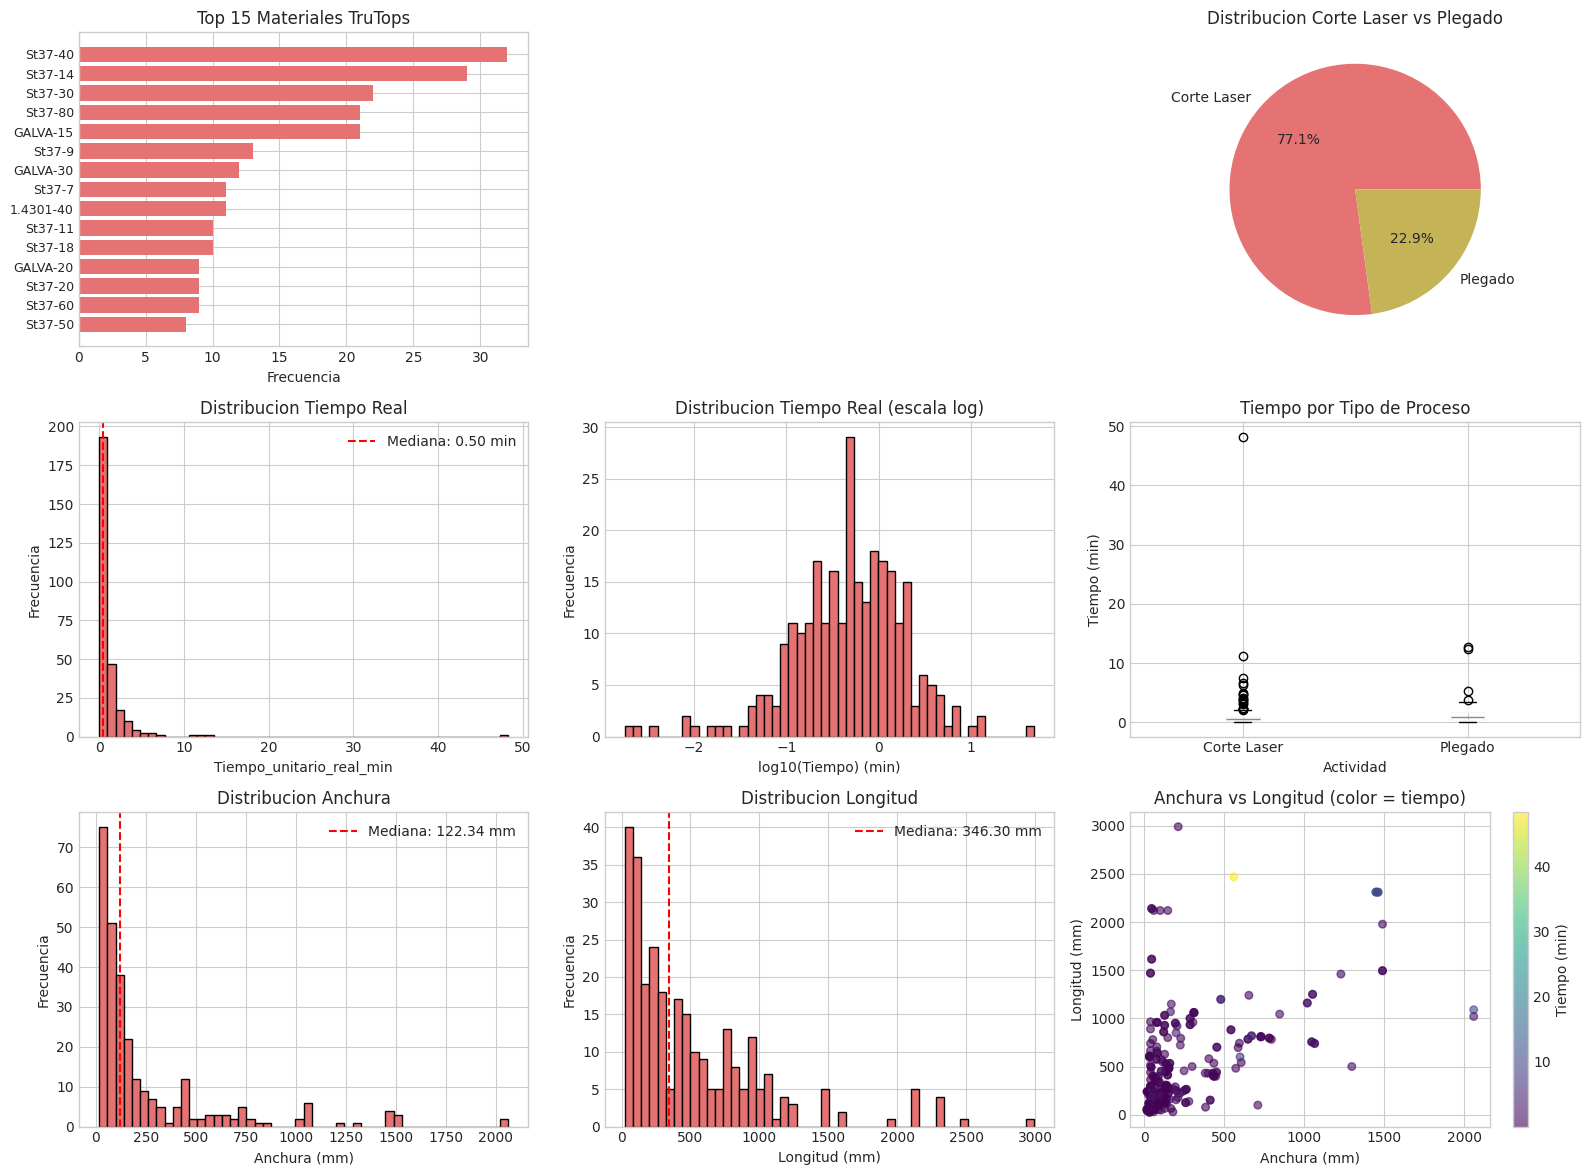

In [17]:
# =============================================================================
# 8. ANALISIS VISUAL DE DISTRIBUCIONES
# =============================================================================

fig = plt.figure(figsize=(16, 12))

# 1. Top 15 Materiales TruTops
plt.subplot(3, 3, 1)
material_counts = df_limpio['MaterialTruTops'].value_counts().head(15)
plt.barh(range(len(material_counts)), material_counts.values, color='#E57373')
plt.yticks(range(len(material_counts)), material_counts.index, fontsize=9)
plt.xlabel('Frecuencia')
plt.title('Top 15 Materiales TruTops')
plt.gca().invert_yaxis()

# 2. Distribucion por Actividad
plt.subplot(3, 3, 3)
actividad_counts = df_limpio['Actividad'].value_counts()
colors = ['#E57373', '#C5B358']
plt.pie(actividad_counts.values, labels=actividad_counts.index, 
        autopct='%1.1f%%', colors=colors)
plt.title('Distribucion Corte Laser vs Plegado')

# 3. Histograma Tiempo Real
plt.subplot(3, 3, 4)
plt.hist(df_limpio['Tiempo_unitario_real_min'], bins=50, 
         edgecolor='black', color='#E57373')
plt.xlabel('Tiempo_unitario_real_min')
plt.ylabel('Frecuencia')
plt.title('Distribucion Tiempo Real')
plt.axvline(df_limpio['Tiempo_unitario_real_min'].median(), color='red', 
            linestyle='--', label=f"Mediana: {df_limpio['Tiempo_unitario_real_min'].median():.2f} min")
plt.legend()

# 4. Histograma Tiempo (escala log)
plt.subplot(3, 3, 5)
tiempo_no_cero = df_limpio[df_limpio['Tiempo_unitario_real_min'] > 0]['Tiempo_unitario_real_min']
plt.hist(np.log10(tiempo_no_cero), bins=50, edgecolor='black', color='#E57373')
plt.xlabel('log10(Tiempo) (min)')
plt.ylabel('Frecuencia')
plt.title('Distribucion Tiempo Real (escala log)')

# 5. Boxplot Tiempo por Actividad
plt.subplot(3, 3, 6)
df_limpio.boxplot(column='Tiempo_unitario_real_min', by='Actividad', ax=plt.gca())
plt.xlabel('Actividad')
plt.ylabel('Tiempo (min)')
plt.title('Tiempo por Tipo de Proceso')
plt.suptitle('')

# 6. Histograma Anchura
plt.subplot(3, 3, 7)
plt.hist(df_limpio['Anchura'], bins=50, edgecolor='black', color='#E57373')
plt.xlabel('Anchura (mm)')
plt.ylabel('Frecuencia')
plt.title('Distribucion Anchura')
plt.axvline(df_limpio['Anchura'].median(), color='red', 
            linestyle='--', label=f"Mediana: {df_limpio['Anchura'].median():.2f} mm")
plt.legend()

# 7. Histograma Longitud
plt.subplot(3, 3, 8)
plt.hist(df_limpio['Longitud'], bins=50, edgecolor='black', color='#E57373')
plt.xlabel('Longitud (mm)')
plt.ylabel('Frecuencia')
plt.title('Distribucion Longitud')
plt.axvline(df_limpio['Longitud'].median(), color='red', 
            linestyle='--', label=f"Mediana: {df_limpio['Longitud'].median():.2f} mm")
plt.legend()

# 8. Scatter Anchura vs Longitud
plt.subplot(3, 3, 9)
scatter = plt.scatter(df_limpio['Anchura'], df_limpio['Longitud'], 
                     c=df_limpio['Tiempo_unitario_real_min'], 
                     cmap='viridis', alpha=0.6, s=30)
plt.xlabel('Anchura (mm)')
plt.ylabel('Longitud (mm)')
plt.title('Anchura vs Longitud (color = tiempo)')
plt.colorbar(scatter, label='Tiempo (min)')

plt.tight_layout()
plt.savefig('analisis_distribuciones.png', dpi=300, bbox_inches='tight')
plt.show()

### Observaciones del analisis visual

1. **Distribucion de tiempos:** Fuertemente sesgada a la derecha (log-normal), mediana 0.5 min
2. **Outliers:** Visibles en boxplot, especialmente en Corte Laser (>40 min)
3. **Dimensiones:** Mayoria de piezas pequenas (<500mm), con algunos casos grandes
4. **Correlacion dimensional:** El scatter muestra que piezas mayores tienden a tiempos mayores (color mas claro)
5. **Material dominante:** St37 (acero) representa la mayoria de registros

=== ANALISIS VISUAL SEPARADO POR PROCESO ===

Registros Corte Laser: 216
Registros Plegado: 64


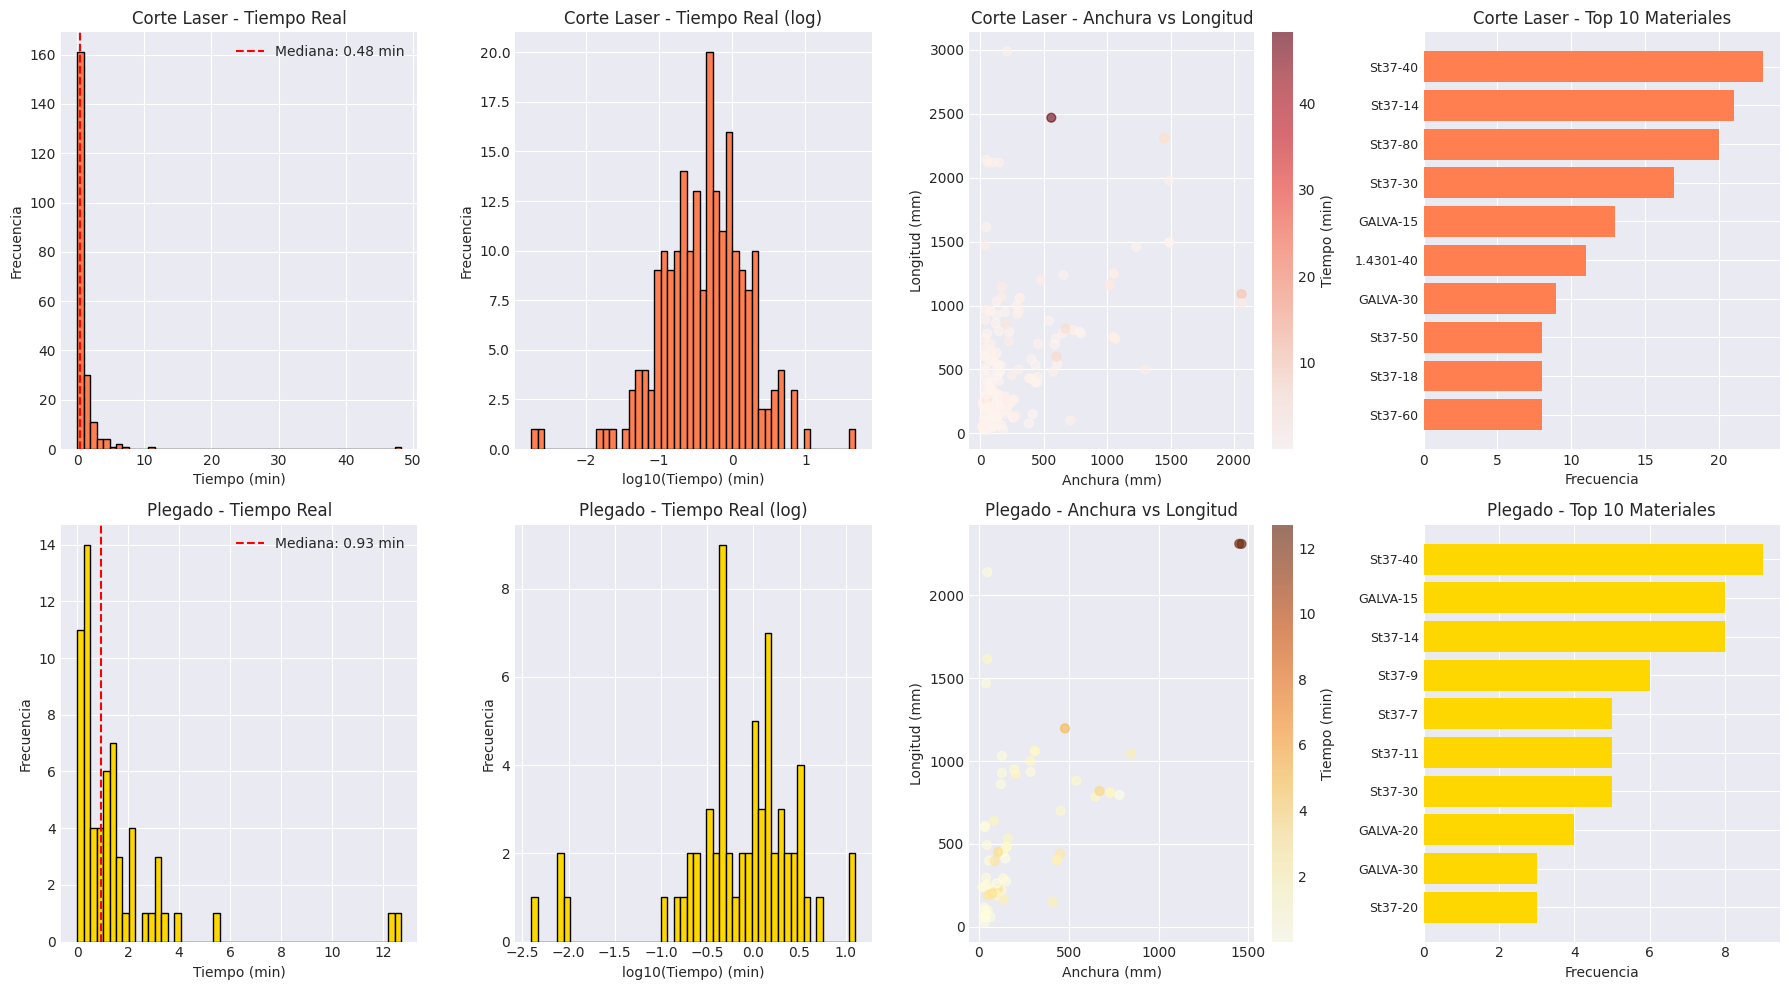


Grafico guardado: analisis_corte_vs_plegado.png


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# SEPARAR POR TIPO DE PROCESO
df_corte = df_limpio[df_limpio['Actividad'] == 'Corte Laser'].copy()
df_plegado = df_limpio[df_limpio['Actividad'] == 'Plegado'].copy()
df_corte_plegado = df_limpio[df_limpio['Actividad'].isin(['Corte Laser', 'Plegado'])]

df_corte.to_csv('df_real_corte.csv', index=False, encoding='utf-8-sig')
df_plegado.to_csv('df_real_plegado.csv', index=False, encoding='utf-8-sig')
df_corte_plegado.to_csv('df_real_corte_plegado.csv', index=False, encoding='utf-8-sig')

print("=== ANALISIS VISUAL SEPARADO POR PROCESO ===\n")
print(f"Registros Corte Laser: {len(df_corte)}")
print(f"Registros Plegado: {len(df_plegado)}")

# CONFIGURACION
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(18, 10))

# ========== CORTE LASER ==========

# 1. Distribucion Tiempo Corte Laser (lineal)
plt.subplot(2, 4, 1)
plt.hist(df_corte['Tiempo_unitario_real_min'], bins=50, edgecolor='black', color='coral')
plt.xlabel('Tiempo (min)')
plt.ylabel('Frecuencia')
plt.title('Corte Laser - Tiempo Real')
plt.axvline(df_corte['Tiempo_unitario_real_min'].median(), color='red', 
            linestyle='--', label=f"Mediana: {df_corte['Tiempo_unitario_real_min'].median():.2f} min")
plt.legend()

# 2. Distribucion Tiempo Corte Laser (log)
plt.subplot(2, 4, 2)
plt.hist(np.log10(df_corte['Tiempo_unitario_real_min']), bins=50, edgecolor='black', color='coral')
plt.xlabel('log10(Tiempo) (min)')
plt.ylabel('Frecuencia')
plt.title('Corte Laser - Tiempo Real (log)')

# 3. Anchura vs Longitud Corte Laser
plt.subplot(2, 4, 3)
scatter = plt.scatter(df_corte['Anchura'], df_corte['Longitud'], 
                     c=df_corte['Tiempo_unitario_real_min'], 
                     cmap='Reds', alpha=0.6, s=40)
plt.xlabel('Anchura (mm)')
plt.ylabel('Longitud (mm)')
plt.title('Corte Laser - Anchura vs Longitud')
plt.colorbar(scatter, label='Tiempo (min)')

# 4. Top materiales Corte Laser
plt.subplot(2, 4, 4)
material_corte = df_corte['MaterialTruTops'].value_counts().head(10)
plt.barh(range(len(material_corte)), material_corte.values, color='coral')
plt.yticks(range(len(material_corte)), material_corte.index, fontsize=9)
plt.xlabel('Frecuencia')
plt.title('Corte Laser - Top 10 Materiales')
plt.gca().invert_yaxis()

# ========== PLEGADO ==========

# 5. Distribucion Tiempo Plegado (lineal)
plt.subplot(2, 4, 5)
plt.hist(df_plegado['Tiempo_unitario_real_min'], bins=50, edgecolor='black', color='gold')
plt.xlabel('Tiempo (min)')
plt.ylabel('Frecuencia')
plt.title('Plegado - Tiempo Real')
plt.axvline(df_plegado['Tiempo_unitario_real_min'].median(), color='red', 
            linestyle='--', label=f"Mediana: {df_plegado['Tiempo_unitario_real_min'].median():.2f} min")
plt.legend()

# 6. Distribucion Tiempo Plegado (log)
plt.subplot(2, 4, 6)
plt.hist(np.log10(df_plegado['Tiempo_unitario_real_min']), bins=50, edgecolor='black', color='gold')
plt.xlabel('log10(Tiempo) (min)')
plt.ylabel('Frecuencia')
plt.title('Plegado - Tiempo Real (log)')

# 7. Anchura vs Longitud Plegado
plt.subplot(2, 4, 7)
scatter = plt.scatter(df_plegado['Anchura'], df_plegado['Longitud'], 
                     c=df_plegado['Tiempo_unitario_real_min'], 
                     cmap='YlOrBr', alpha=0.6, s=40)
plt.xlabel('Anchura (mm)')
plt.ylabel('Longitud (mm)')
plt.title('Plegado - Anchura vs Longitud')
plt.colorbar(scatter, label='Tiempo (min)')

# 8. Top materiales Plegado
plt.subplot(2, 4, 8)
material_plegado = df_plegado['MaterialTruTops'].value_counts().head(10)
plt.barh(range(len(material_plegado)), material_plegado.values, color='gold')
plt.yticks(range(len(material_plegado)), material_plegado.index, fontsize=9)
plt.xlabel('Frecuencia')
plt.title('Plegado - Top 10 Materiales')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('analisis_corte_vs_plegado.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafico guardado: analisis_corte_vs_plegado.png")

### Comparativa Corte Laser vs Plegado

| Caracteristica | Corte Laser | Plegado |
|----------------|-------------|---------|
| Registros | 216 (77%) | 64 (23%) |
| Mediana tiempo | 0.48 min | 0.93 min |
| Material principal | St37-40 | St37-40 |

**Observaciones:**
- Plegado tiene tiempos unitarios mayores (casi el doble en mediana)
- Ambos procesos muestran distribucion log-normal
- St37 domina en ambos procesos

## 9. Exportacion de Datasets

Se exportan los datasets limpios para uso en los notebooks de modelado.

In [19]:
# =============================================================================
# 9. EXPORTACION DE DATASETS
# =============================================================================

# Crear directorio de salida si no existe
from pathlib import Path
OUTPUT_PATH = Path('datos_procesados')
OUTPUT_PATH.mkdir(exist_ok=True)

# Dataset completo (Corte Laser + Plegado)
df_limpio.to_csv(OUTPUT_PATH / 'datos_reales_limpios.csv', index=False, encoding='utf-8-sig')
print(f"Exportado: datos_reales_limpios.csv ({len(df_limpio)} registros)")

# Datasets separados por actividad
df_laser = df_limpio[df_limpio['Actividad'] == 'Corte Laser']
df_plegado = df_limpio[df_limpio['Actividad'] == 'Plegado']

df_laser.to_csv(OUTPUT_PATH / 'datos_reales_corte_laser.csv', index=False, encoding='utf-8-sig')
print(f"Exportado: datos_reales_corte_laser.csv ({len(df_laser)} registros)")

df_plegado.to_csv(OUTPUT_PATH / 'datos_reales_plegado.csv', index=False, encoding='utf-8-sig')
print(f"Exportado: datos_reales_plegado.csv ({len(df_plegado)} registros)")

# Resumen de columnas exportadas
print(f"\n{'='*60}")
print("COLUMNAS EXPORTADAS")
print(f"{'='*60}")
for col in df_limpio.columns:
    print(f"  - {col}")

Exportado: datos_reales_limpios.csv (280 registros)
Exportado: datos_reales_corte_laser.csv (216 registros)
Exportado: datos_reales_plegado.csv (64 registros)

COLUMNAS EXPORTADAS
  - Nº pieza
  - Denominación de pieza
  - Tipo de pieza
  - Material en bruto
  - Actividad
  - Estado de FT
  - Tiempo de mecanizado nominal [min]
  - Tiempo de mecanizado real [min]
  - Cantidad real
  - Peso por unidad
  - Anchura
  - Longitud
  - MaterialTruTops
  - Tipo_Material
  - Espesor_mm
  - Tiempo_unitario_real_min
  - bounding_box_area
  - aspect_ratio
  - perimetro_aproximado
  - Tiempo_unitario_nominal_min
  - bounding_box_area_mm2
  - perimetro_aproximado_mm
  - dim_max
  - dim_min
  - peso_kg


## Resumen del Pipeline ETL

### Flujo de datos

| Etapa | Registros | Descripcion |
|-------|-----------|-------------|
| Carga inicial | 914 | Dataset de produccion |
| Combinacion con catalogo | 914 | Merge con articulos y tipos |
| Filtro por actividad | 347 | Solo Corte Laser + Plegado |
| Limpieza de calidad | 280 | Eliminar tiempo=0, geometria invalida |
| **Dataset final** | **280** | 216 Corte Laser + 64 Plegado |

### Archivos generados

| Archivo | Registros | Uso |
|---------|-----------|-----|
| `datos_reales_limpios.csv` | 280 | Dataset completo |
| `datos_reales_corte_laser.csv` | 216 | Modelo principal |
| `datos_reales_plegado.csv` | 64 | Modelo secundario |

### Features disponibles para modelado

**Variables objetivo:**
- `Tiempo_unitario_real_min`: tiempo real por pieza

**Features geometricas:**
- `bounding_box_area_mm2`, `perimetro_aproximado_mm`
- `dim_max`, `dim_min`, `aspect_ratio`
- `Anchura`, `Longitud`

**Features de material:**
- `MaterialTruTops`, `Tipo_Material`, `Espesor_mm`, `peso_kg`
```

## Output esperado:
```
Exportado: datos_reales_limpios.csv (280 registros)
Exportado: datos_reales_corte_laser.csv (216 registros)
Exportado: datos_reales_plegado.csv (64 registros)

============================================================
COLUMNAS EXPORTADAS
============================================================
  - Nº pieza
  - Denominación de pieza
  - Tipo de pieza
  - Material en bruto
  - Actividad
  - Estado de FT
  - Tiempo de mecanizado nominal [min]
  - Tiempo de mecanizado real [min]
  - Cantidad real
  - Peso por unidad
  - Anchura
  - Longitud
  - MaterialTruTops
  - Tipo_Material
  - Espesor_mm
  - Tiempo_unitario_real_min
  - bounding_box_area
  - aspect_ratio
  - perimetro_aproximado
  - Tiempo_unitario_nominal_min
  - bounding_box_area_mm2
  - perimetro_aproximado_mm
  - dim_max
  - dim_min
  - peso_kg

## ANEXO TEST MODELO REAL

In [26]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')


# =============================================================================
# 1. CONFIGURACIÓN DE FEATURES Y TARGET
# =============================================================================

FEATURES_GEOMETRICAS = [
    'bounding_box_area_mm2',
    'perimetro_aproximado_mm',
    'aspect_ratio',
    'dim_max',
    'dim_min',
    'peso_kg'
]

TARGET = 'Tiempo_unitario_real_min'
TARGET_NOMINAL = 'Tiempo_unitario_nominal_min'
GRUPO = 'MaterialTruTops'


# =============================================================================
# 2. FUNCIONES DE PREPARACIÓN DE DATOS
# =============================================================================

def preparar_datos(df, features, target, grupo, target_nominal=None):
    """
    Prepara los datos eliminando nulos y validando columnas.
    
    Parameters
    ----------
    df : DataFrame
        Dataset con los datos de producción
    features : list
        Lista de columnas a usar como features
    target : str
        Columna objetivo
    grupo : str
        Columna de agrupación (MaterialTruTops)
    target_nominal : str, optional
        Columna de tiempo nominal para baseline
    
    Returns
    -------
    DataFrame limpio y listo para modelado
    """
    columnas_necesarias = features + [target, grupo]
    
    # Añadir nominal si existe
    if target_nominal and target_nominal in df.columns:
        columnas_necesarias.append(target_nominal)
    
    # Verificar columnas existentes
    columnas_faltantes = [col for col in columnas_necesarias if col not in df.columns]
    if columnas_faltantes:
        raise ValueError(f"Columnas faltantes: {columnas_faltantes}")
    
    # Seleccionar y limpiar
    df_prep = df[columnas_necesarias].copy()
    n_inicial = len(df_prep)
    df_prep = df_prep.dropna()
    n_final = len(df_prep)
    
    print(f"Registros: {n_inicial} → {n_final} (eliminados {n_inicial - n_final} con nulos)")

    # Eliminar filas donde tiempo nominal = tiempo real (datos sospechosos)
    if target_nominal and target_nominal in df_prep.columns:
        n_antes = len(df_prep)
        df_prep = df_prep[df_prep[target] != df_prep[target_nominal]]
        n_iguales = n_antes - len(df_prep)
        print(f"Eliminados {n_iguales} registros con tiempo real = nominal")
    
    # Filtrar outliers extremos en target (opcional)
    q99 = df_prep[target].quantile(0.99)
    q01 = df_prep[target].quantile(0.01)
    df_prep = df_prep[(df_prep[target] >= q01) & (df_prep[target] <= q99)]
    print(f"Después de filtrar outliers: {len(df_prep)} registros")
    
    return df_prep


def analisis_por_material(df, target, grupo):
    """
    Análisis descriptivo por tipo de material.
    """
    resumen = df.groupby(grupo)[target].agg([
        'count', 'mean', 'std', 'min', 'median', 'max'
    ]).round(3)
    resumen.columns = ['N', 'Media', 'Std', 'Min', 'Mediana', 'Max']
    return resumen.sort_values('N', ascending=False)


# =============================================================================
# 3. PIPELINE DE MODELADO
# =============================================================================

def crear_pipelines():
    """
    Crea diccionario de pipelines con diferentes modelos.
    """
    pipelines = {
        'Ridge': Pipeline([
            ('scaler', RobustScaler()),
            ('model', Ridge(alpha=1.0))
        ]),
        'Lasso': Pipeline([
            ('scaler', RobustScaler()),
            ('model', Lasso(alpha=0.1))
        ]),
        'ElasticNet': Pipeline([
            ('scaler', RobustScaler()),
            ('model', ElasticNet(alpha=0.1, l1_ratio=0.5))
        ]),
        'RandomForest': Pipeline([
            ('scaler', RobustScaler()),  # RF no lo necesita, pero mantiene consistencia
            ('model', RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                min_samples_leaf=5,
                random_state=42,
                n_jobs=-1
            ))
        ]),
        'GradientBoosting': Pipeline([
            ('scaler', RobustScaler()),
            ('model', GradientBoostingRegressor(
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
                random_state=42
            ))
        ])
    }
    return pipelines


def evaluar_modelo(y_true, y_pred, nombre_modelo=""):
    """
    Calcula métricas de evaluación.
    """
    metricas = {
        'Modelo': nombre_modelo,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'R2': r2_score(y_true, y_pred)
    }
    return metricas


def entrenar_evaluar_por_material(df, features, target, grupo, test_size=0.2):
    """
    Entrena y evalúa modelos por cada tipo de material.
    
    Parameters
    ----------
    df : DataFrame
        Datos preparados
    features : list
        Features geométricas
    target : str
        Variable objetivo
    grupo : str
        Columna de agrupación
    test_size : float
        Proporción de test
    
    Returns
    -------
    dict con resultados por material y modelo
    """
    materiales = df[grupo].unique()
    pipelines = crear_pipelines()
    
    resultados_globales = []
    modelos_entrenados = {}
    
    print("\n" + "="*70)
    print("EVALUACIÓN DE MODELOS POR MATERIAL")
    print("="*70)
    
    for material in materiales:
        df_material = df[df[grupo] == material]
        n_samples = len(df_material)
        
        # Mínimo de muestras para entrenar
        if n_samples < 6:
            print(f"\n{material}: Solo {n_samples} muestras - OMITIDO")
            continue
        
        print(f"\n{'─'*70}")
        print(f"MATERIAL: {material} (n={n_samples})")
        print(f"{'─'*70}")
        
        X = df_material[features]
        y = df_material[target]
        
        # Split estratificado no es posible en regresión, usamos random
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        
        print(f"Train: {len(X_train)} | Test: {len(X_test)}")
        
        mejor_r2 = -np.inf
        mejor_modelo = None
        
        for nombre, pipeline in pipelines.items():
            try:
                # Entrenar
                pipeline.fit(X_train, y_train)
                
                # Predecir
                y_pred = pipeline.predict(X_test)
                
                # Evaluar
                metricas = evaluar_modelo(y_test, y_pred, nombre)
                metricas['Material'] = material
                metricas['N_samples'] = n_samples
                resultados_globales.append(metricas)
                
                # Track mejor modelo
                if metricas['R2'] > mejor_r2:
                    mejor_r2 = metricas['R2']
                    mejor_modelo = nombre
                
                print(f"  {nombre:20s} | MAE: {metricas['MAE']:.3f} | "
                      f"RMSE: {metricas['RMSE']:.3f} | R²: {metricas['R2']:.3f}")
                
            except Exception as e:
                print(f"  {nombre:20s} | ERROR: {str(e)[:40]}")
        
        # Guardar mejor modelo para este material
        if mejor_modelo:
            modelos_entrenados[material] = {
                'modelo': mejor_modelo,
                'pipeline': pipelines[mejor_modelo],
                'r2': mejor_r2
            }
            print(f"  → Mejor: {mejor_modelo} (R²={mejor_r2:.3f})")
    
    # Crear DataFrame de resultados
    df_resultados = pd.DataFrame(resultados_globales)
    
    return df_resultados, modelos_entrenados


def resumen_mejores_modelos(df_resultados):
    """
    Genera resumen de mejores modelos por material.
    """
    # Mejor modelo por material según R²
    idx_mejor = df_resultados.groupby('Material')['R2'].idxmax()
    mejores = df_resultados.loc[idx_mejor].copy()
    mejores = mejores.sort_values('R2', ascending=False)
    
    return mejores[['Material', 'Modelo', 'N_samples', 'MAE', 'RMSE', 'MAPE', 'R2']]


def comparar_con_nominal(df, target_real, target_nominal, grupo):
    """
    Compara tiempo real vs nominal como baseline.
    """
    print("\n" + "="*70)
    print("COMPARACIÓN REAL VS NOMINAL (BASELINE)")
    print("="*70)
    
    resultados = []
    
    for material in df[grupo].unique():
        df_mat = df[df[grupo] == material]
        
        if len(df_mat) < 10:
            continue
            
        y_real = df_mat[target_real]
        y_nominal = df_mat[target_nominal]
        
        # Métricas del nominal como "predicción"
        mae = mean_absolute_error(y_real, y_nominal)
        mape = mean_absolute_percentage_error(y_real, y_nominal) * 100
        
        # Correlación
        corr = y_real.corr(y_nominal)
        
        # Sesgo medio (nominal - real)
        sesgo = (y_nominal - y_real).mean()
        
        resultados.append({
            'Material': material,
            'N': len(df_mat),
            'MAE_nominal': mae,
            'MAPE_nominal': mape,
            'Correlacion': corr,
            'Sesgo_medio': sesgo
        })
    
    df_baseline = pd.DataFrame(resultados)
    df_baseline = df_baseline.sort_values('N', ascending=False)
    
    return df_baseline


# =============================================================================
# 4. FUNCIÓN PRINCIPAL DE EJECUCIÓN
# =============================================================================

def ejecutar_pipeline_completo(df_proceso, nombre_proceso="Proceso"):
    """
    Ejecuta el pipeline completo para un proceso (Laser o Plegado).
    
    Parameters
    ----------
    df_proceso : DataFrame
        Dataset filtrado por tipo de proceso
    nombre_proceso : str
        Nombre del proceso para los prints
    
    Returns
    -------
    tuple: (df_resultados, mejores_modelos, df_baseline)
    """
    print("\n" + "="*70)
    print(f"PIPELINE DE PREDICCIÓN - {nombre_proceso.upper()}")
    print("="*70)
    
    # 1. Preparar datos
    print("\nPreparando datos...")
    df_prep = preparar_datos(
        df_proceso, 
        FEATURES_GEOMETRICAS, 
        TARGET, 
        GRUPO,
        TARGET_NOMINAL
    )
    
    # 2. Análisis descriptivo
    print("\nDistribución por material:")
    resumen = analisis_por_material(df_prep, TARGET, GRUPO)
    print(resumen.head(10).to_string())
    
    # 3. Baseline: comparar con nominal
    if TARGET_NOMINAL in df_proceso.columns:
        df_baseline = comparar_con_nominal(
            df_prep, TARGET, TARGET_NOMINAL, GRUPO
        )
        print("\nBaseline (Nominal vs Real):")
        print(df_baseline.head(10).to_string(index=False))
    else:
        df_baseline = None
        print("\nNo se encontró columna de tiempo nominal")
    
    # 4. Entrenar y evaluar modelos
    df_resultados, modelos = entrenar_evaluar_por_material(
        df_prep, FEATURES_GEOMETRICAS, TARGET, GRUPO
    )
    
    # 5. Resumen de mejores modelos
    print("\n" + "="*70)
    print("RESUMEN: MEJORES MODELOS POR MATERIAL")
    print("="*70)
    mejores = resumen_mejores_modelos(df_resultados)
    print(mejores.to_string(index=False))
    
    # 6. Estadísticas globales
    print("\nESTADÍSTICAS GLOBALES:")
    print(f"   Materiales evaluados: {df_resultados['Material'].nunique()}")
    print(f"   R² promedio (mejor modelo): {mejores['R2'].mean():.3f}")
    print(f"   R² mediano (mejor modelo): {mejores['R2'].median():.3f}")
    print(f"   MAE promedio: {mejores['MAE'].mean():.3f} min")
    
    return df_resultados, mejores, df_baseline



np.random.seed(42)



resultados, mejores, baseline = ejecutar_pipeline_completo(
    df_laser, 
    nombre_proceso="Corte Láser"
)



PIPELINE DE PREDICCIÓN - CORTE LÁSER

Preparando datos...
Registros: 216 → 216 (eliminados 0 con nulos)
Eliminados 47 registros con tiempo real = nominal
Después de filtrar outliers: 165 registros

Distribución por material:
                  N  Media   Std   Min  Mediana   Max
MaterialTruTops                                      
St37-40          23  1.241 1.565 0.033    0.632 6.341
St37-80          20  1.456 0.901 0.359    1.207 3.803
St37-14          18  0.976 1.488 0.043    0.653 6.667
St37-30          15  0.602 0.879 0.022    0.203 3.318
GALVA-15         11  0.232 0.138 0.074    0.212 0.484
1.4301-40         8  0.424 0.290 0.051    0.373 0.867
St37-60           8  1.420 1.267 0.300    0.868 3.899
St37-50           8  1.035 0.629 0.224    1.175 2.014
St37-7            6  0.346 0.238 0.175    0.278 0.801
St37-9            6  0.270 0.206 0.096    0.213 0.677

COMPARACIÓN REAL VS NOMINAL (BASELINE)

Baseline (Nominal vs Real):
Material  N  MAE_nominal  MAPE_nominal  Correlacion  Sesg